In [5]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from collections import Counter
import math
import statistics as stats

In [6]:
'''
Loading the file
Change the file name for different experiments
'''
f = sio.loadmat('walkingLarge1.mat')
fhist = f['fHist']
pc = fhist['pointCloud']
header= fhist['header']
ts = fhist['timestamp']
num_points = fhist['numInputPoints']


In [7]:
def moving_average(x, window_size=3):
    """ Compute a moving average.
    
    Example 1: moving_average([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], window_size=3) returns
        [(1 + 2 + 3) / 3, (2 + 3 + 4) / 3, (3 + 4 + 5) / 3, (4 + 5 + 6) / 3]
        which is [2.0, 3.0, 4.0, 5.0].
    
    Example 2: moving_average([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], window_size=5) returns
        [(1 + 2 + 3 + 4 + 5) / 5, (2 + 3 + 4 + 5 + 6) / 5]
        which is [3.0, 4.0].
    
    Args:
        x: A list of floats.
        window_size: A positive, odd integer.
        
    Returns:
        A list of floats.
    """
    if window_size % 2 != 1:
        raise ValueError('window_size must be odd.')
    if window_size > len(x):
        raise ValueError('window_size should be smaller than len(x).')
        
    # TODO: Replace with valid code.
    y = None
    y = []
    sum = [0]

    for i, xi in enumerate(x, 1):
      sum.append(sum[i-1] + xi)
      if i>=window_size:
        mov_ave = (sum[i] - sum[i-window_size])/window_size
        y.append(mov_ave)

    return y

In [8]:
def padded_moving_average(x, window_size=3):
    """ Compute a moving average.
    
    This differs from moving_average in that the input is first
    padded on both sides with an appropriate number of 0s, so that
    the output has the same length as x and so that x and y are
    aligned.
    
    Example: padded_moving_average([1.0, 1.0, 1.0], window_size=3) returns
        [(0 + 1 + 1) / 3, (1 + 1 + 1) / 3, (1 + 1 + 0) / 3]
        which has approximate values of [0.66, 1.0, 0.66].
    
    Args:
        x: A list of floats.
        window_size: A positive, odd integer that's less than the length of .
        
    Returns:
        A list of floats.
    """
    # TODO: Replace with valid code
    y = None
    ba = int((window_size-1)/2)
    x = [0]*ba + x + [0]*ba
    y = moving_average(x, window_size)    
    return y

In [9]:
def filterByStd(x, y1, y2, y3):
    newx=[]
    newy1=[]
    newy2=[]
    newy3=[]
    sig = np.std(x)
    m = np.mean(x)
    for i in range(len(x)):
        if x[i] < m + 3*sig and x[i] > m - 3*sig:
            newx.append(x[i])
            newy1.append(y1[i])
            newy2.append(y2[i])
            newy3.append(y3[i])
    return newx, newy1, newy2, newy3

In [10]:
def filterByIQR(x,y1,y2,y3):
    '''
    filter by x(range)
    return output in time order(y1)
    '''
    newx=[]
    newy1=[]
    newy2=[]
    newy3=[]
    index = np.argsort(x)
    x.sort()
    q1,q3= np.percentile(x,[25,75])
    print(q1)
    print(q3)
    iqr = q3 - q1
    lower_bound = q1 -(3 * iqr) 
    upper_bound = q3 +(3 * iqr) 
    for i in range(len(x)):
        if x[i] >= lower_bound and x[i] <= upper_bound:
            newx.append(x[i])
            newy1.append(y1[index[i]])
            newy2.append(y2[index[i]])
            newy3.append(y3[index[i]])
    tindex = np.argsort(newy1)
    nx=[]
    ny2=[]
    ny3=[]
    newy1.sort()
    for i in range(len(newy1)):
        nx.append(newx[tindex[i]])
        ny2.append(newy2[tindex[i]])
        ny3.append(newy3[tindex[i]])
    return nx,newy1,ny2,ny3

In [11]:
def partition(x, y1, y2, y3):
    '''
    Partition of y1, y2, y3 into 2 segments based on x values
    '''

    diff = np.max(x) - np.min(x)
    x1=[]
    x2=[]
    y11=[]
    y12=[]
    y21=[]
    y22=[]
    y31=[]
    y32=[]
    for i in range(len(x)):
        if x[i] < np.min(x) + diff/2:
            x1.append(x[i])
            y11.append(y1[i])
            y21.append(y2[i])
            y31.append(y3[i])
        else:
            x2.append(x[i])
            y12.append(y1[i])
            y22.append(y2[i])
            y32.append(y3[i])
#    x1,y11,y21,y31 = filterByStd(x1,y11,y21,y31)
#    x2,y12,y22,y32 = filterByStd(x2,y12,y22,y32)
    
    return x1,y11,y21,y31,x2,y12,y22,y32
        
            

In [12]:
def toEuc(r, theta):
    return [r*math.cos(theta),r*math.sin(theta)]

In [13]:
def centroid(pos):
    length = len(pos)
    x_loc = 0
    y_loc = 0
    if length == 0:
        return None
    for i in range(length):
        x_loc += pos[i][0]
        y_loc += pos[i][1]
    return [x_loc/length, y_loc/length]

In [14]:
def dist(loc1,loc2):
    if loc1 == None or loc2 == None:
        return 0
    return math.sqrt(math.pow(loc2[0]-loc1[0], 2) + math.pow(loc2[1]-loc1[1], 2))

In [15]:
def velocityEstimation(pos,time):
    
    length = len(pos)
    velocity = []
    t = time[0]
    loc = []
    newt = []
    instantRange=[]
    for i in range(length):
        if time[i] == t:
            instantRange.append(pos[i])
        else:
            c = centroid(instantRange)
            newt.append(t)
            loc.append(c)
            instantRange = [pos[i]]
            t = time[i]
   # print(loc)
   # print(newt)
    for i in range(len(loc)):
        if i%5 == 0 and not i == 0:
            velocity.append(dist(loc[i],loc[i-5])/(newt[i]-newt[i-5]))
    return (velocity, stats.median(velocity))
    '''
    for i in range(len(pos)):
        
    first = pos[0]
    last = pos[len(pos)-1]
    t0 = time[0]
    tlast = time[len(time)-1]
    print(first,last,t0,tlast,dist(first,last))
    
    result = dist(first,last)/(tlast-t0)
    return result
    '''


In [19]:
#total time of the video
#change this for different experiments!!
#tt=30

dp=[]
snr=[]
r=[]
time=[]
angle=[]
pos=[]
rangeSTD=[]
midRangeIntensity=[]
frameTime=[]

#fhist.shape[1]
for i in range(fhist.shape[1]):
    #calculate the standard deviations and mean of points range data
    rdata = []
    for k in range(num_points[0,i][0,0]):
        rdata.append(pc[0,i][0,k])
    if len(rdata)!=0:
        sig = np.std(rdata)
        m = np.mean(rdata)
    
    #find range, snr, time, doppler value of data points
    temp=[]
    pointsCollected = False
    for j in range(num_points[0,i][0,0]):
        #clean the data
        if pc[0,i][0,j] > m + 3*sig or pc[0,i][0,j] < m - 3*sig:
            continue

        if pc[0,i][3,j] <= 0:
            snr.append(0.00000000001)
        if pc[0,i][3,j] > 0:
            snr.append(10*np.log10(pc[0,i][3,j]))
   #     t = header[0,i]['timestamp'][0,0][0][0]
        dp.append(pc[0,i][2,j])
        r.append(pc[0,i][0,j])
        angle.append(pc[0,i][1,j])
        time.append(i/20)
        pos.append(toEuc(pc[0,i][0,j],pc[0,i][1,j]))
        temp.append(pc[0,i][0,j])
        medianIndex = np.argsort(temp)[len(temp)//2]
        pointsCollected = True
    if pointsCollected:
        frameTime.append(i/20)
        rangeSTD.append(np.std(temp))
        midRangeIntensity.append(10*np.log10(pc[0,i][3,medianIndex]))

snr = padded_moving_average(snr,3)

#print(np.mean(r))

r,time,snr,dp = filterByIQR(r,time,snr,dp)

#print(np.mean(r))

#r1,t1,s1,d1,r2,t2,s2,d2 = partition(r,time,snr,dp)
print(len(pos))
print(len(time))

2.4917516708374023
4.690356254577637
2105
2105


In [30]:

'''
import csv
with open('1_rotating_slow_1_fast.csv', mode='w') as myfile:
    w = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    w.writerow(r1)
    w.writerow(t1)
    w.writerow(s1)
    w.writerow(d1)
    w.writerow(r2)
    w.writerow(t2)
    w.writerow(s2)
    w.writerow(d2)
'''

"\nimport csv\nwith open('1_rotating_slow_1_fast.csv', mode='w') as myfile:\n    w = csv.writer(myfile, quoting=csv.QUOTE_ALL)\n    w.writerow(r1)\n    w.writerow(t1)\n    w.writerow(s1)\n    w.writerow(d1)\n    w.writerow(r2)\n    w.writerow(t2)\n    w.writerow(s2)\n    w.writerow(d2)\n"

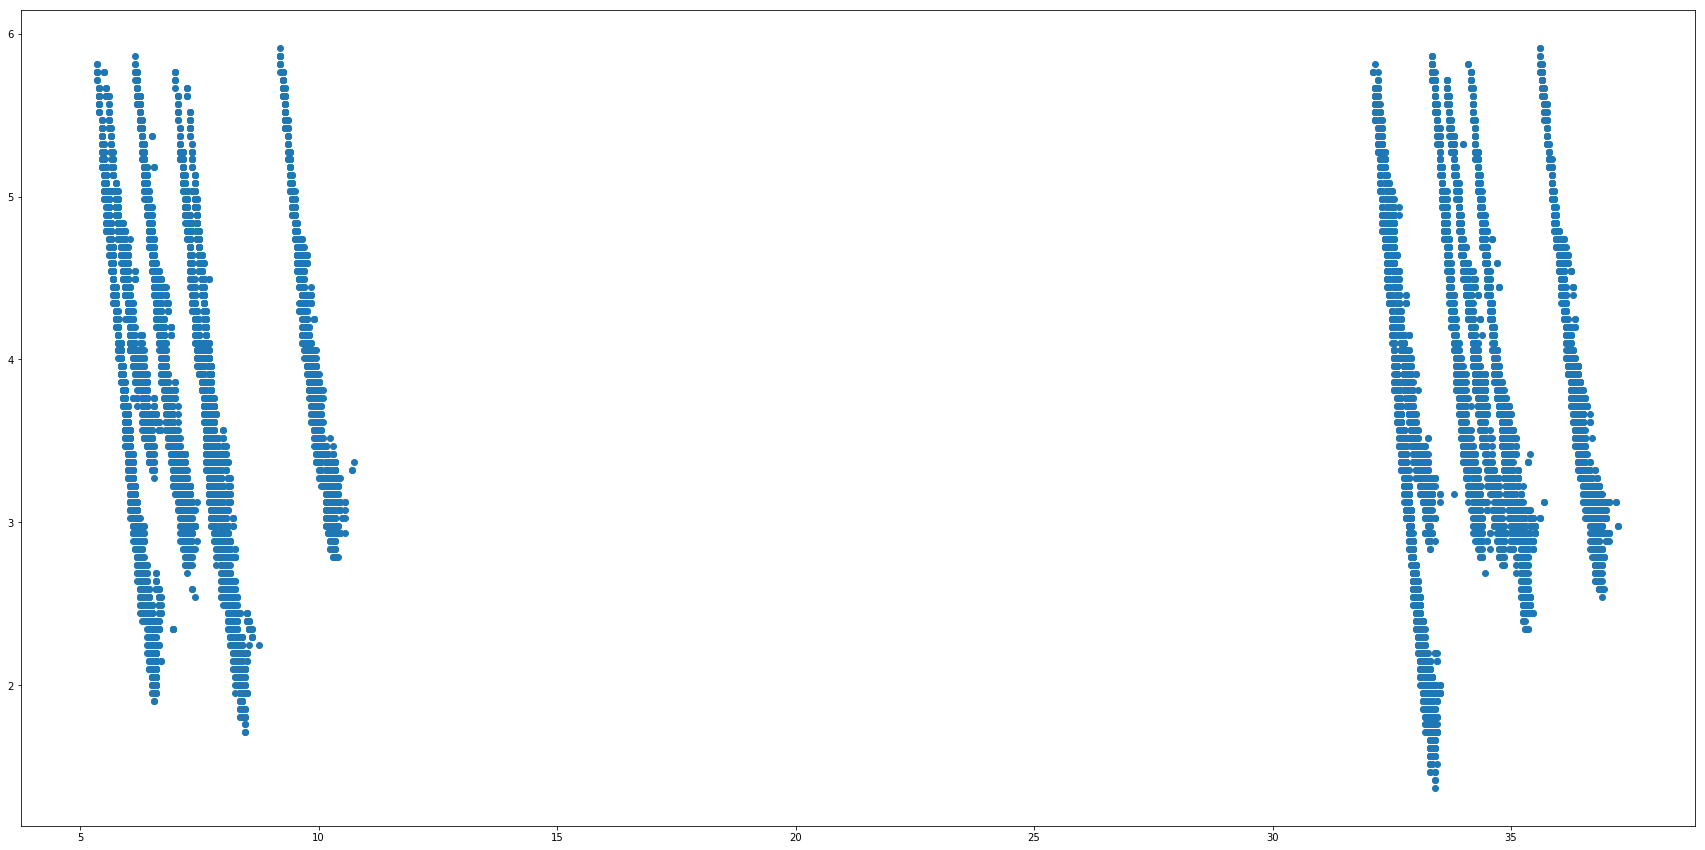

In [33]:
fig1 = plt.figure(figsize = (30,15))
#plt.ylim(-3,3)
p=plt.scatter(time,r)
#p=plt.scatter([row[0] for row in c1],[row[1] for row in c1],20,marker='x',color='red')
#p=plt.scatter([row[0] for row in c2],[row[1] for row in c2],20,marker='x',color='black')
#p=plt.scatter([row[0] for row in c3],[row[1] for row in c3],20,marker='x',color='pink')
#p=plt.scatter([row[0] for row in c4],[row[1] for row in c4],20,marker='x',color='blue')

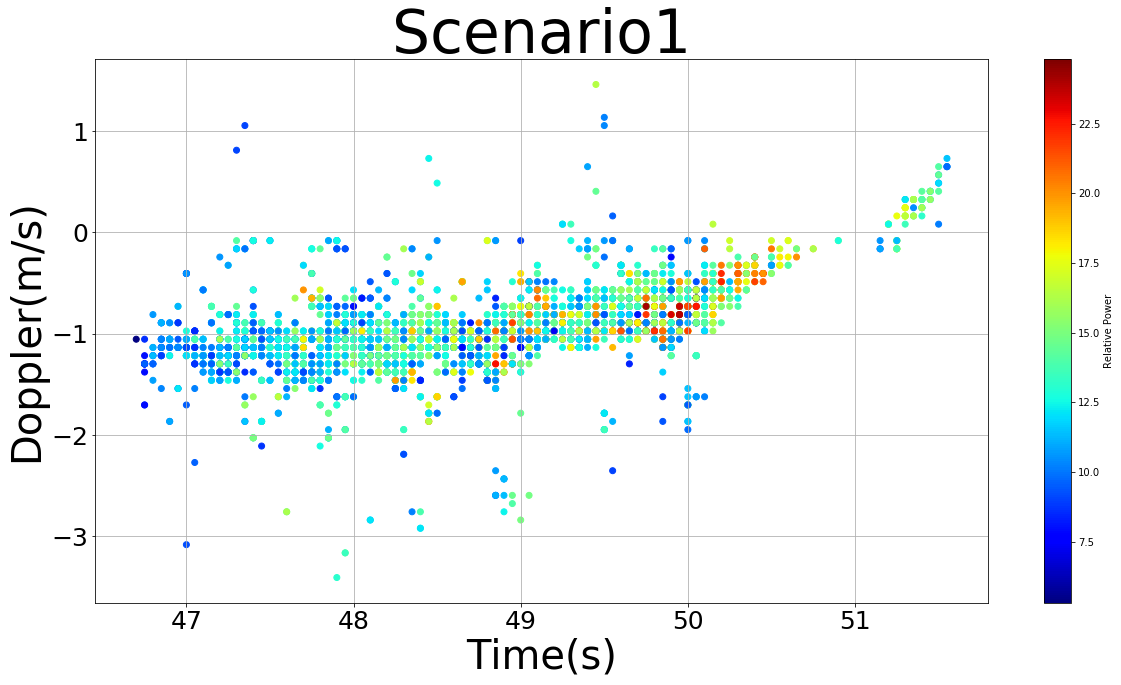

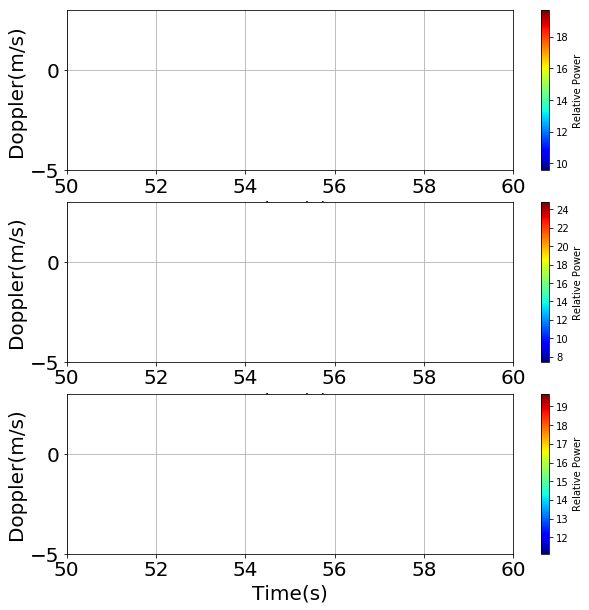

In [570]:
'''
Doppler vs Time plot
'''
fig2 = plt.figure(figsize = (20,10))
p=plt.scatter(time,dp,c=snr, cmap='jet')
#p=plt.scatter([row[0] for row in c2],[row[2] for row in c2],20,marker='x',color='red')
plt.title('Scenario1', fontsize=60)
plt.xlabel('Time(s)',fontsize=40)
plt.ylabel('Doppler(m/s)',fontsize=40)
plt.tick_params(labelsize=25)
plt.colorbar().set_label('Relative Power')
#plt.title(h, 'Relative Power')
#plt.xlim(68,72)
#plt.ylim(-2,2)
plt.grid(True)
#plt.ylim(-3,3)
#p=plt.scatter(time,dp)

fig2 = plt.figure(figsize = (10,10))

plt.subplot(3,1,1)
p=plt.scatter([row[0] for row in c1],[row[2] for row in c1],20,marker='o',c=[row[3] for row in c1], cmap='jet')
#plt.title('Scenario2', fontsize=30)
plt.ylim(-5,3)
plt.xlim(50,60)
plt.xlabel('Time(s)',fontsize=20)
plt.ylabel('Doppler(m/s)',fontsize=20)
plt.tick_params(labelsize=20)
plt.colorbar().set_label('Relative Power')
plt.grid(True)
plt.subplot(3,1,2)
p=plt.scatter([row[0] for row in c2],[row[2] for row in c2],20,marker='x',c=[row[3] for row in c2], cmap='jet')

#plt.title('twoArmSwinging1', fontsize=60)
#plt.xlim(15,25)
plt.ylim(-5,3)
plt.xlim(50,60)
plt.xlabel('Time(s)',fontsize=20)
plt.ylabel('Doppler(m/s)',fontsize=20)
plt.colorbar().set_label('Relative Power')
plt.tick_params(labelsize=20)
plt.grid(True)
plt.subplot(3,1,3)
p=plt.scatter([row[0] for row in c3],[row[2] for row in c3],20,marker='x',c=[row[3] for row in c3], cmap='jet')

#plt.title('twoArmSwinging1', fontsize=60)
#plt.xlim(15,25)
plt.ylim(-5,3)
plt.xlim(50,60)
plt.xlabel('Time(s)',fontsize=20)
plt.ylabel('Doppler(m/s)',fontsize=20)
plt.colorbar().set_label('Relative Power')
plt.tick_params(labelsize=20)
plt.grid(True)


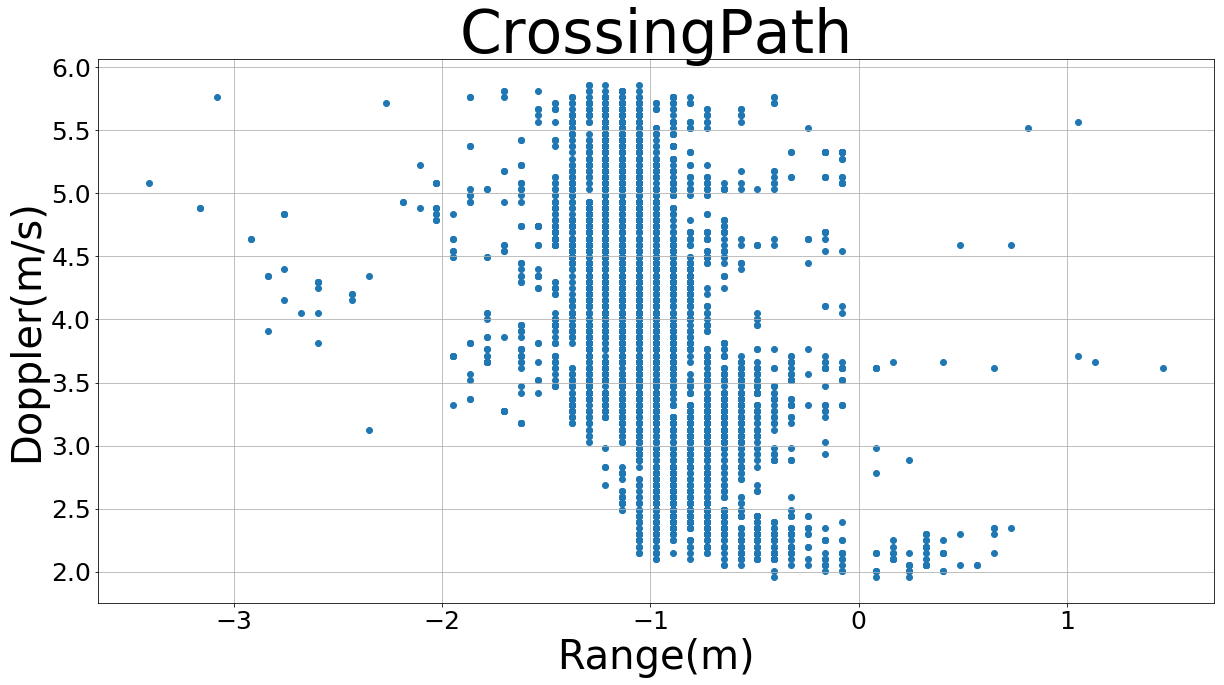

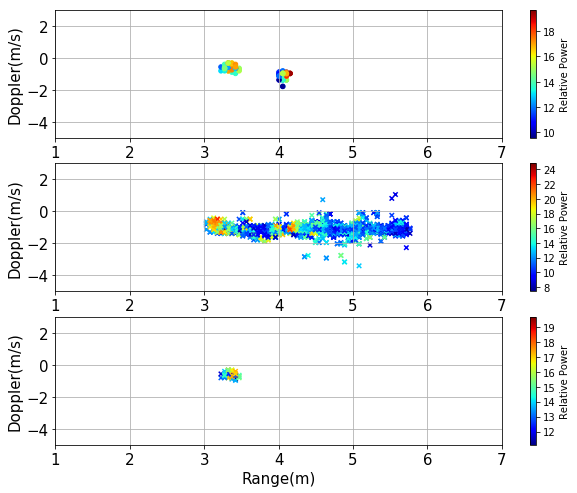

In [571]:
'''
Doppler vs Range plot
'''
fig2 = plt.figure(figsize = (20,10))
p=plt.scatter(dp,r)
plt.title('CrossingPath', fontsize=60)
plt.xlabel('Range(m)',fontsize=40)
plt.ylabel('Doppler(m/s)',fontsize=40)
plt.tick_params(labelsize=25)
#plt.xlim(15,25)
#plt.ylim(-3,3)
plt.grid(True)

fig2 = plt.figure(figsize = (10,8))

plt.subplot(3,1,1)
p=plt.scatter([row[1] for row in c1],[row[2] for row in c1],20,marker='o',c=[row[3] for row in c1], cmap='jet')
#plt.title('CrossingPath', fontsize=60)
plt.ylim(-5,3)
plt.xlim(1,7)
plt.xlabel('Range(m)',fontsize=15)
plt.ylabel('Doppler(m/s)',fontsize=15)
plt.tick_params(labelsize=15)
plt.colorbar().set_label('Relative Power')
plt.grid(True)
plt.subplot(3,1,2)
p=plt.scatter([row[1] for row in c2],[row[2] for row in c2],20,marker='x',c=[row[3] for row in c2], cmap='jet')
#plt.title('Scenario1', fontsize=60)
#plt.title('twoArmSwinging1', fontsize=60)
#plt.xlim(15,25)
plt.ylim(-5,3)
plt.xlim(1,7)
plt.xlabel('Range(m)',fontsize=15)
plt.ylabel('Doppler(m/s)',fontsize=15)
plt.tick_params(labelsize=15)
plt.colorbar().set_label('Relative Power')
plt.grid(True)
plt.subplot(3,1,3)
p=plt.scatter([row[1] for row in c3],[row[2] for row in c3],20,marker='x',c=[row[3] for row in c3], cmap='jet')
#plt.title('Scenario1', fontsize=60)
#plt.title('twoArmSwinging1', fontsize=60)
#plt.xlim(15,25)
plt.ylim(-5,3)
plt.xlim(1,7)
plt.xlabel('Range(m)',fontsize=15)
plt.ylabel('Doppler(m/s)',fontsize=15)
plt.tick_params(labelsize=15)
plt.colorbar().set_label('Relative Power')
plt.grid(True)

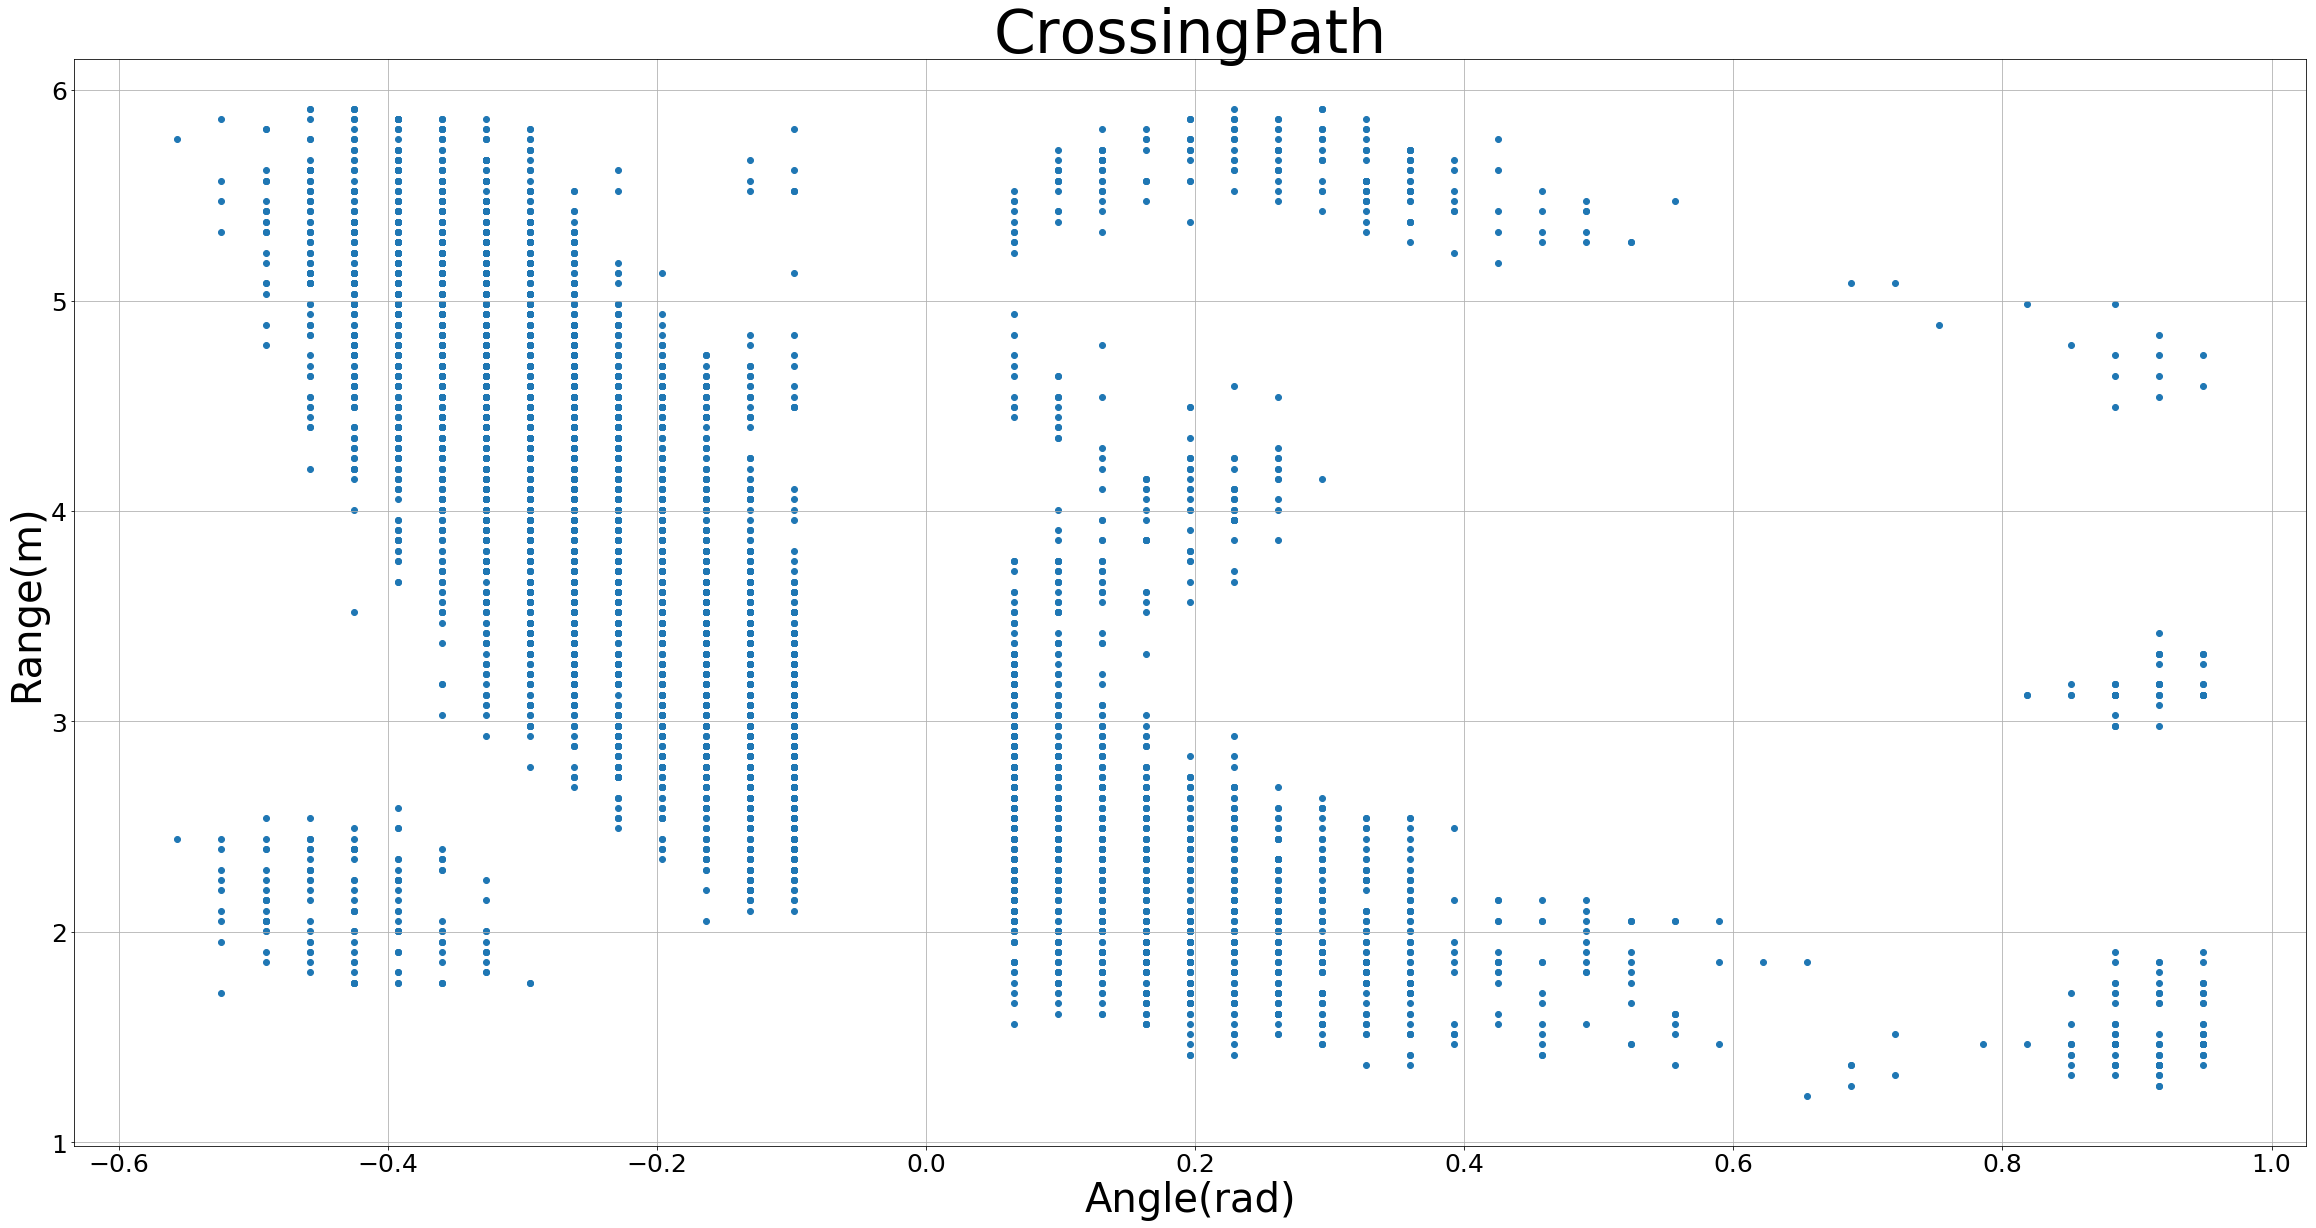

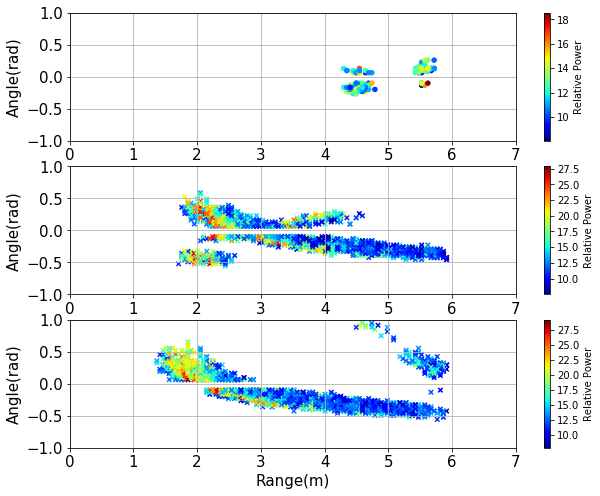

In [481]:
'''
Range vs Angle plot
'''
fig2 = plt.figure(figsize = (40,20))
p=plt.scatter(angle,r)
plt.title('CrossingPath', fontsize=60)
plt.xlabel('Angle(rad)',fontsize=40)
plt.ylabel('Range(m)',fontsize=40)
plt.tick_params(labelsize=25)
#plt.xlim(15,25)
#plt.ylim(-3,3)
plt.grid(True)

fig2 = plt.figure(figsize = (10,8))

plt.subplot(3,1,1)
p=plt.scatter([row[1] for row in c1],[row[5] for row in c1],20,marker='o',c=[row[3] for row in c1], cmap='jet')
#plt.title('CrossingPath', fontsize=60)
plt.ylim(-1,1)
plt.xlim(0,7)
plt.xlabel('Range(m)',fontsize=15)
plt.ylabel('Angle(rad)',fontsize=15)
plt.tick_params(labelsize=15)
plt.colorbar().set_label('Relative Power')
plt.grid(True)
plt.subplot(3,1,2)
p=plt.scatter([row[1] for row in c2],[row[5] for row in c2],20,marker='x',c=[row[3] for row in c2], cmap='jet')
#plt.title('Scenario1', fontsize=60)
#plt.title('twoArmSwinging1', fontsize=60)
plt.ylim(-1,1)
plt.xlim(0,7)
plt.xlabel('Range(m)',fontsize=15)
plt.ylabel('Angle(rad)',fontsize=15)
plt.tick_params(labelsize=15)
plt.colorbar().set_label('Relative Power')
plt.grid(True)
plt.subplot(3,1,3)
p=plt.scatter([row[1] for row in c3],[row[5] for row in c3],20,marker='x',c=[row[3] for row in c3], cmap='jet')
#plt.title('Scenario1', fontsize=60)
#plt.title('twoArmSwinging1', fontsize=60)
plt.ylim(-1,1)
plt.xlim(0,7)
plt.xlabel('Range(m)',fontsize=15)
plt.ylabel('Angle(rad)',fontsize=15)
plt.tick_params(labelsize=15)
plt.colorbar().set_label('Relative Power')
plt.grid(True)

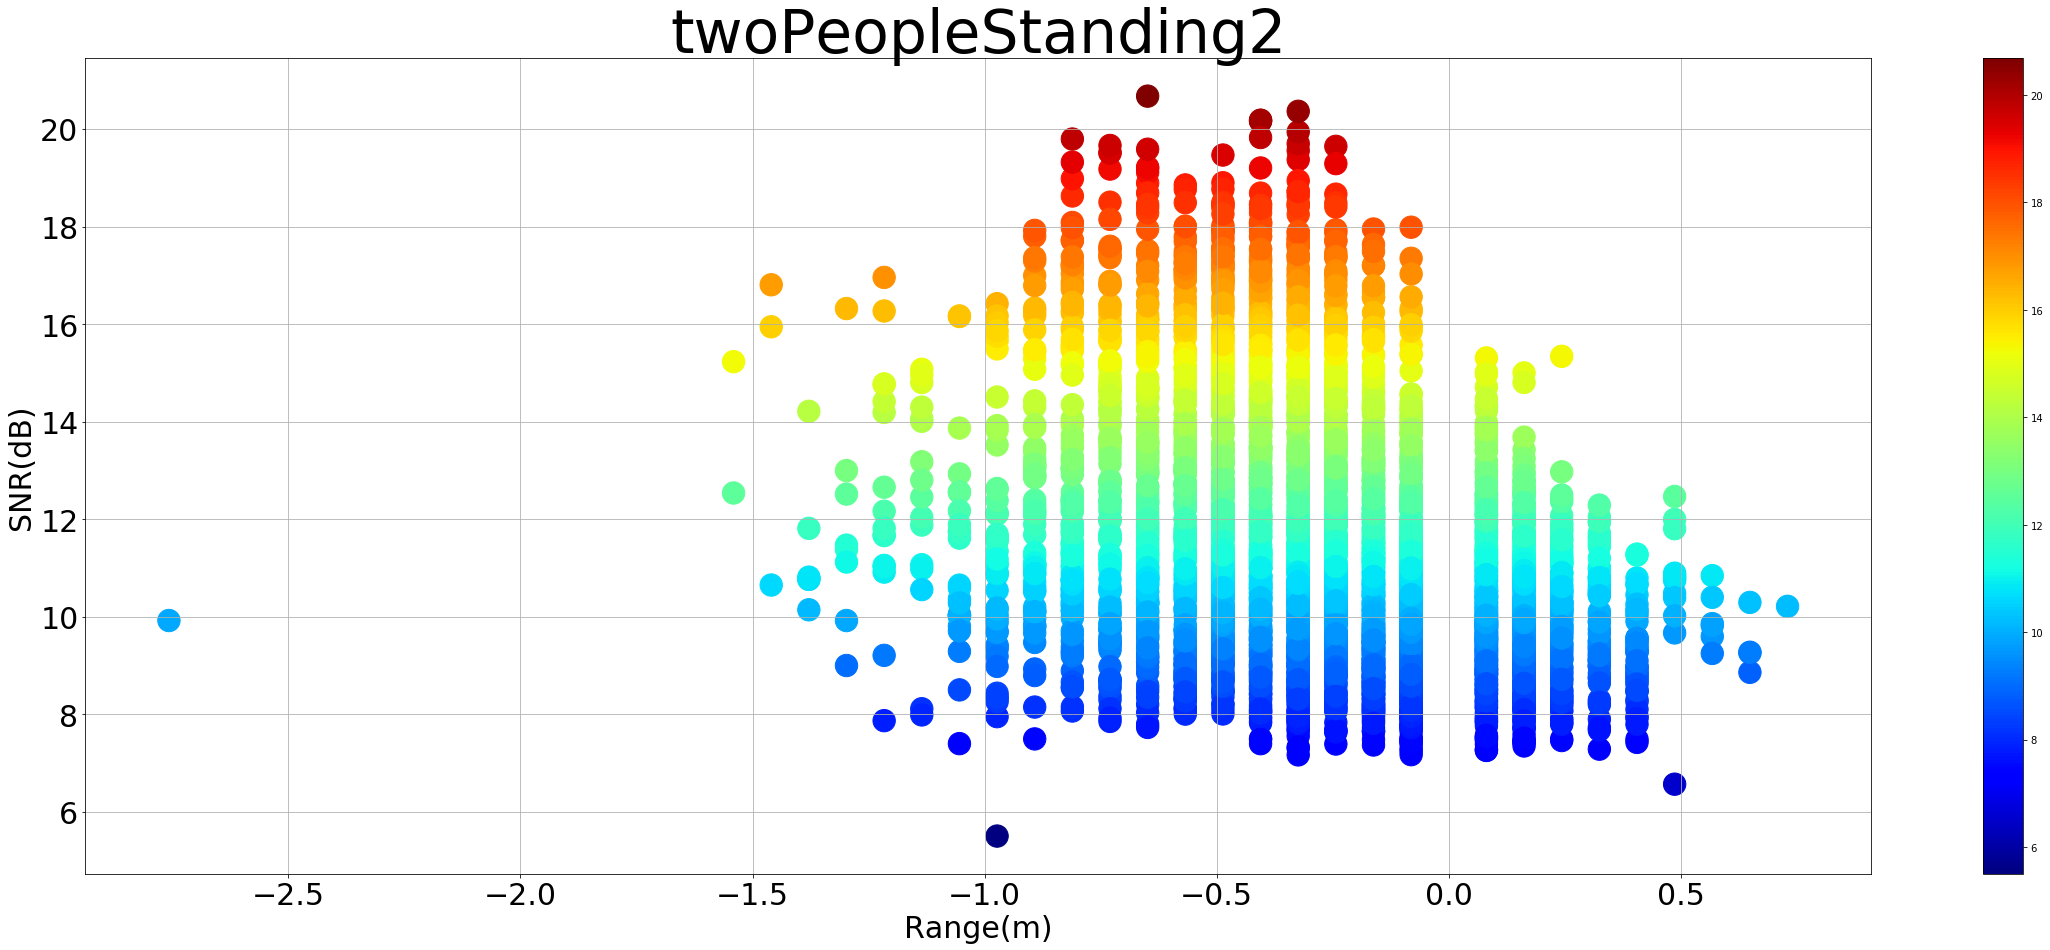

In [251]:
fig = plt.figure(figsize = (40,15))
p1=plt.scatter(dp,snr, c=snr, cmap='jet', s=500)
plt.title('twoPeopleStanding2', fontsize=60)

#plt.ylim(0,40)
#plt.xlim(2,4)
plt.xlabel('Range(m)',fontsize=30)
plt.ylabel('SNR(dB)',fontsize=30)
plt.colorbar()
plt.tick_params(labelsize=30)
plt.grid(True)